In [23]:
#  import dependencies needed for spatial / geospatial data
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

In [3]:
df = pd.read_csv("Meteorite_Landings.csv")

# display basic info
print(df.info()) # check column types and missing values
print(df.head()) #first 5 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
 10  Unnamed: 10  0 non-null      float64
dtypes: float64(5), int64(1), object(5)
memory usage: 3.8+ MB
None
       name   id nametype     recclass  mass (g)  fall    year    reclat  \
0    Aachen    1    Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid          EH4  107000.0  

In [11]:
# check for missing values
print(df.isnull().sum())

# Drop rows with missing essential values (latitude, longitude, mass)
df = df.dropna(subset=['reclat', 'reclong', 'mass (g)'])

# Fill missing values in 'year' with a placeholder (e.g., 0 or the median year)
df['year'] = df['year'].fillna(0)

name               0
id                 0
nametype           0
recclass           0
mass (g)           0
fall               0
year               0
reclat             0
reclong            0
GeoLocation        0
Unnamed: 10    38282
dtype: int64


In [13]:
# Convert 'year' to an integer
df['year'] = df['year'].astype(int)

# Convert 'mass (g)' to float
df['mass (g)'] = df['mass (g)'].astype(float)

# Rename columns for consistency
df = df.rename(columns={
    'name': 'Name',
    'id': 'ID',
    'recclass': 'Type',
    'mass (g)': 'Mass_g',
    'fall': 'Fall_Status',
    'year': 'Year',
    'reclat': 'Latitude',
    'reclong': 'Longitude',
})

# Convert column names to lowercase for easier referencing
df.columns = df.columns.str.lower()

print(df.head())  # Check cleaned dataset

       name   id nametype         type    mass_g fall_status  year  latitude  \
0    Aachen    1    Valid           L5      21.0        Fell  1880  50.77500   
1    Aarhus    2    Valid           H6     720.0        Fell  1951  56.18333   
2      Abee    6    Valid          EH4  107000.0        Fell  1952  54.21667   
3  Acapulco   10    Valid  Acapulcoite    1914.0        Fell  1976  16.88333   
4   Achiras  370    Valid           L6     780.0        Fell  1902 -33.16667   

   longitude           geolocation  unnamed: 10  
0    6.08333     (50.775, 6.08333)          NaN  
1   10.23333  (56.18333, 10.23333)          NaN  
2 -113.00000    (54.21667, -113.0)          NaN  
3  -99.90000     (16.88333, -99.9)          NaN  
4  -64.95000   (-33.16667, -64.95)          NaN  


In [14]:
# Calculate the 99th percentile for mass to filter extreme outliers
mass_threshold = np.percentile(df['mass_g'], 99)

# Remove extreme outliers
df = df[df['mass_g'] <= mass_threshold]

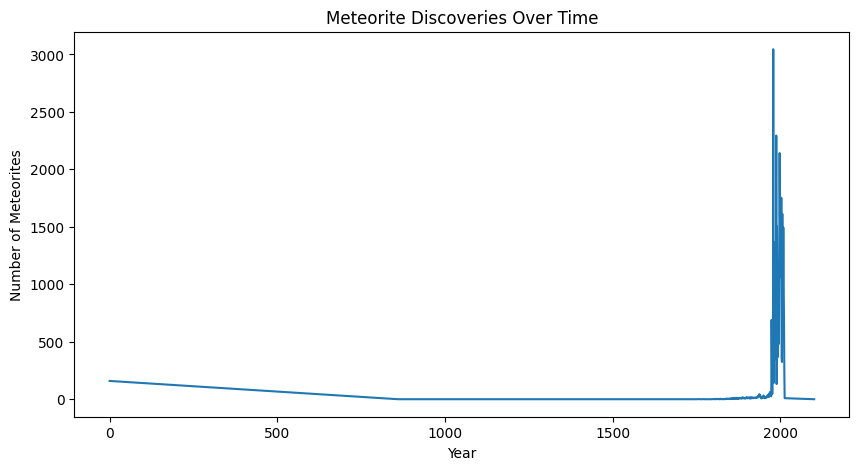

In [26]:
# Plot the number of meteorites found per year
df['year'].value_counts().sort_index().plot(kind='line', figsize=(10,5))
plt.xlabel("Year")
plt.ylabel("Number of Meteorites")
plt.title("Meteorite Discoveries Over Time")
plt.show()

In [27]:
# Create a world map centered at (0,0)
m = folium.Map(location=[0, 0], zoom_start=2)

# Sample 1000 meteorites for performance
sample_df = df.sample(n=min(1000, len(df)), random_state=42)

# Add meteorite landings as points
for _, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=max(2, np.log(row['mass_g'] + 1)),  # Scale marker size by mass
        color='red' if row['fall_status'] == 'Fell' else 'blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['name']} ({row['year']}) - {row['mass_g']}g"
    ).add_to(m)

# Display the map in Google Colab
from IPython.display import display
display(m)

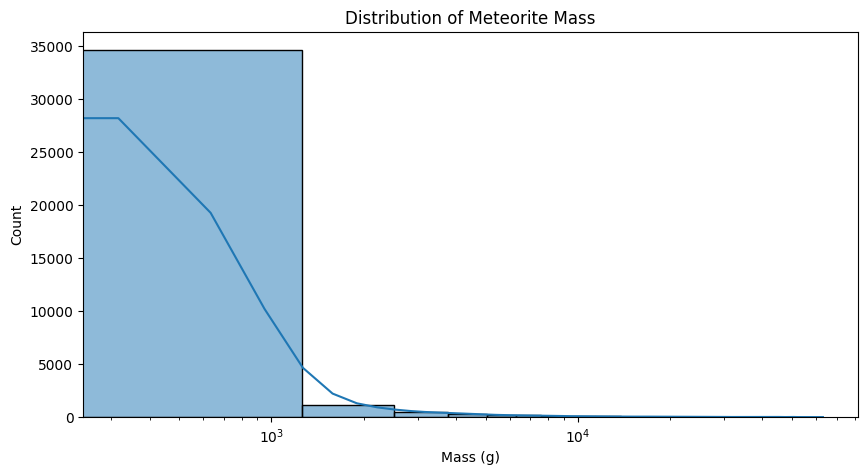

In [19]:
import seaborn as sns

# Plot the distribution of meteorite mass
plt.figure(figsize=(10, 5))
sns.histplot(df['mass_g'], bins=50, kde=True)
plt.xscale("log")  # Log scale because mass has large variations
plt.xlabel("Mass (g)")
plt.ylabel("Count")
plt.title("Distribution of Meteorite Mass")
plt.show()


In [20]:
# Top 10 largest meteorites
top_meteorites = df.sort_values(by="mass_g", ascending=False).head(10)

print(top_meteorites[['name', 'mass_g', 'year', 'latitude', 'longitude']])


                      name   mass_g  year  latitude  longitude
1011                Treysa  63000.0  1916  50.91667    9.18333
36883          Santa Clara  63000.0  1976  24.46667 -103.35000
6866    Derrick Peak 88017  63000.0  1988 -80.06667  156.38333
37871       Tanezrouft 072  62285.0  2002  24.43817    0.10300
38010               Thunda  62100.0  1881 -25.70000  143.05000
12630           Gold Basin  61000.0  1995  35.87500 -114.23333
5554                Covert  61000.0  1896  39.20000  -98.78333
26382      Nicolás Levalle  60000.0  1956 -38.85028  -62.87889
36903             Savannah  60000.0  1923  35.16667  -88.18333
16384  Hex River Mountains  60000.0  1882 -33.31667   19.61667
